# nb 02: write data to ```hrr_cobot```

**This is the continuation of the tutorial 01 notebook. Please understand how to read data from the cobot before sending data
You can also find additional information about underlying docus  and startup procedures**


**UPDATE: imports have slightly changed**

- ROS-control interfaces are now in hrr_controllers
- abbreaviations have been removed to ease readability


## Imports / Packages needed

In [1]:
# math and robotics
import numpy as np
import quaternion
from tqdm.notebook import tqdm, trange

# plotting 
import seaborn as sns
import matplotlib.pylab as plt

# ROS
import rospy

# hrr-cobot packages
import hrr_common
import hrr_cobot_robot
import hrr_controllers

# set printing and plotting options    
np.set_printoptions(precision=5, suppress=True)
sns.set_theme('notebook')
%matplotlib notebook

## Send Command to Robot Tests / Tutorial
###### connect to ROS 

optionally set the ```ROS_IP``` and ```ROS_MASTER_URI``` directly form this notebook, as
the setup above spawns the ros-setup from the real-time client, i.e. ```hrrN3511rt2004.lsr.ei.tum.de```

In [2]:
def get_hostname_and_IP():
    import socket
    with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as s:
        s.connect(("8.8.8.8", 80))
        return socket.gethostname(), s.getsockname()[0]

_host, _ip = get_hostname_and_IP()
%env ROS_MASTER_URI=http://127.0.0.1:11311
# %env ROS_MASTER_URI=http://hrrcobotLinux54:11311
print(f"\t\033[1m\033[4m!!!please check that the IPs below is identical!!!\033[0m"+
      f"\n\thost {_host} has IP {_ip}, which should be identical to",end="\nvs:\t")
%env ROS_IP=$_ip

env: ROS_MASTER_URI=http://127.0.0.1:11311
	!!!please check that the IPs below is identical!!!
	host hrrN3511rt2004 has IP 192.168.1.35, which should be identical to
vs:	env: ROS_IP=192.168.1.35


In [3]:
rospy.init_node("hrr_cobot_tutorial02")

### Status interface

The command of the COMAU robots also require the state to be defined properly. 
So we add a comaustatus handle from the tutorial 01 notebook below, to double check the current robot
state.

This state should be in ```moving``` for the Sensor-track controller and in ```ready``` for the trajectory-handler(s)

In [4]:
comau_status = hrr_controllers.ComauRobotState.from_ros("/hrr_cobot")
rospy.sleep(1e-1)
comau_status.robot_status

'ready'

In [5]:
def legal_traj():
    return comau_status.robot_status == 'ready'

def legal_sns():
    return comau_status.robot_status == 'moving'

## Sensor-track control 


### EE-velocity control (```hrr_controllers.SnsTrkCmd```)

This class API exects to communicate with a ```sensor_track_velocity_controller``` controller as provided by the
```hrr_controllers``` package. For this controller, the command is given as the dedicated twist in world frame, i.e.

$$ 
\begin{bmatrix} \delta x & \delta y & \delta z & \delta \theta & \delta \psi & \delta \phi \end{bmatrix}^{\top}
:= \begin{bmatrix} v_x & v_y & v_z & \omega_x & \omega_y & \omega_z \end{bmatrix}^{\top} \cdot \Delta t
$$

the client-side, i.e. the ```hrr_controllers.SnsTrkCmd``` handle is epxected to command the Cartesian velocity of the end-effector of the robot, which is then forwarded to a C

The controller needs the following ros-parameters

- the sensor-track-topic name, this is a message of type [TwistStamped](http://docs.ros.org/en/api/geometry_msgs/html/msg/TwistStamped.html) that sets the current end-effector velocity to the robot
- the controller manager ros-namespace to communicate with the controller manager
- the name of the sensor-track-velocity controller

In contrast to the read-command handles, this handle does not provide any information about the robot and is also not printed in any pretty format to ease information exchange

**WARNING: THIS HANDLE IS EXPECTED TO BE WRAPPED WITH INTELLIGENCE OR USED WITH CARE!**

**THERE EXISTS NO SAFETY CHECK AGAINST SPEED VIOLATION / EXCEEDED FORCE LIMITS / COLLISIONS**

In [6]:
# rospy.set_param("~sns_trk_topic_name", "/hrr_cobot/sensor_track_velocity_controller/tcp_v_cmd")
# rospy.set_param("~controller_manager_ns", "/hrr_cobot/controller_manager")
# rospy.set_param("~sns_trk_vel_controller_name", "sensor_track_velocity_controller")
# sns_trk_vel_cmd = hrr_controllers.SnsTrkCmd.from_ros("~")
sns_trk_vel_cmd = hrr_controllers.SnsTrkCmd.from_ros("/hrr_cobot")

### check controller status

> **The commands shown below are calid for all controller-APIs shown in this notebook, i.e. also for**
> - ```SnstrkComplCmd```
> - ```JointTrajectoryHandler```

In contrast to the state-controller, that are loaded by default, the status of the controllers need to be checked. 
We can use some helper functions provided in the ```hrr_common``` package.
For convinience, they are integrated into the sensor-tracking controllers

##### print active controllers

In [7]:
sns_trk_vel_cmd.list_controllers()

joint_state_controller                  	=>	 running 
cartesian_state_controller              	=>	 running 
comau_robot_state_controller            	=>	 running 
ft_state_controller                     	=>	 running 
sensor_track_velocity_controller        	=>	initialized
joint_trajectory_handler                	=>	initialized
kolver_program                          	=>	initialized
kolver_run                              	=>	initialized
shaft_grinder                           	=>	initialized
tool_changer                            	=>	initialized
vacuum_controller                       	=>	initialized
[unloaded] sensor_track_compliant_controller	[hrr_controllers/CompliancePoseController]
[unloaded] cartesian_trajectory_handler  	[comau_controllers/CartesianTrajectoryHandler]
[unloaded] digital_io_state_controller   	[hrr_controllers/DigitalIOStateController]
[unloaded] gimatic_encoder_controller    	[hrr_controllers/DoutEncoderController]


##### activate controller and confirm status

the identical procedure is available with ```deactivate()``` but is spared due to triviality here

In [8]:
sns_trk_vel_cmd.activate()

In [9]:
sns_trk_vel_cmd.activate()
sns_trk_vel_cmd.list_controllers()
sns_trk_vel_cmd.active

joint_state_controller                  	=>	 running 
cartesian_state_controller              	=>	 running 
comau_robot_state_controller            	=>	 running 
ft_state_controller                     	=>	 running 
sensor_track_velocity_controller        	=>	 running 
joint_trajectory_handler                	=>	initialized
kolver_program                          	=>	initialized
kolver_run                              	=>	initialized
shaft_grinder                           	=>	initialized
tool_changer                            	=>	initialized
vacuum_controller                       	=>	initialized
[unloaded] sensor_track_compliant_controller	[hrr_controllers/CompliancePoseController]
[unloaded] cartesian_trajectory_handler  	[comau_controllers/CartesianTrajectoryHandler]
[unloaded] digital_io_state_controller   	[hrr_controllers/DigitalIOStateController]
[unloaded] gimatic_encoder_controller    	[hrr_controllers/DoutEncoderController]


True

##### confirm with robot status

if the controller is activated in sensor-tracking mode, the robot status (see tutorial 01) needs to be in moving, otherwise there is something malconfigured.

checklist, ```comau_status.robot_status``` is 

- ```69``` $\rightarrow$  some bug in the driver $\rightarrow$  restart the ROS-robot driver
- ```terminate``` $\rightarrow$ check [workaround in the wiki](https://wiki.tum.de/x/VAELMg)
- ```moving``` $\rightarrow$ alright, proceed

In [10]:
legal_sns(), comau_status.robot_status

(True, 'moving')

##### send test data to robot

**use with care:**
slow movements only (Cart velocity is provided in SI-units, so max-speed should be 0.05 m/s or 50 mm/s
and 0.1 rad/s for first trials.

In [22]:
sns_trk_vel_cmd.stop()

In [20]:
r = rospy.Rate(50)
v_test = np.zeros(6)
for t in trange(200):
    v_test[0] = 0#5e-3 * np.sin(t/ 100.0 * 2 * np.pi)
    v_test[1] = 0#8e-3 * np.sin(t/ 100.0 * 2 * np.pi)
    v_test[2] = 8e-3 * np.sin(t/ 100.0 * 2 * np.pi)
    sns_trk_vel_cmd.update_cmd(v_test)
    r.sleep() 
sns_trk_vel_cmd.stop()

  0%|          | 0/200 [00:00<?, ?it/s]

**send orientation commands to the robot**

The sensor-tracking control is counter-intuitive when used directly due to the strange conventions of the sensor-tracking interface.

The sensor-tracking interface assumes a Cartesian deviation commended to the end-effector of the robot relative to the base frame of the robot.
Usually you would assume the output of the Jacobian or a Cartesian Servoing speed command to send the Cartesian velocity of the end-effector to be set in the current frame of the end-effector.

In contrast byt default the sensor-tracking velocity controller would steer the robot end-effector around the global coordinate system. This is understandable for translation but may lead to undesired behavior in rotation.

You have two options to alternate this behavior:

1. adjust the velocity to the convention of the sensor-tracking frame before sending it, e.g.

   ```python
   v_cmd = my_magic_function()  # some function returning the desired end-effector velocity
   v_sns = cobot.T_E_B_robot.jacob() @ v_cmd
   ```
   
2. use the ```update_cmd``` command and add the referred frame you want the robot to follow the current control

In [25]:
r = rospy.Rate(50)
v_test = np.zeros(6)
v_test[3] = 0.05
for t in trange(50):
    sns_trk_vel_cmd.update_cmd(v_test, comau_status._base_frame)
    r.sleep()
sns_trk_vel_cmd.stop()

  0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
r = rospy.Rate(50)
v_test = np.zeros(6)
v_test[2] = 0.01
for t in trange(50):
    sns_trk_vel_cmd.update_cmd(v_test, comau_status._base_frame)
    r.sleep()
for t in trange(50):
    sns_trk_vel_cmd.update_cmd(v_test, "hrr_cobot.ee_link")
    r.sleep()
sns_trk_vel_cmd.stop()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [27]:
sns_trk_vel_cmd.deactivate()

### Hybrid compliance control (```hrr_controllers.SnsTrkComplCmd```)

>**WARNING: THIS CONTROLLER IS CURRENTLY NOT SUPPORTED; SKIP THIS SECTION**


the controller expects the following parameters to be set

- ```sns_trk_compl_controller_name```
- ```cmd_topic_name```
- ```control_select_topic_name```
- ```gain_cfg_name```

The controller follows the following control command

$$
\begin{aligned}
{\bf {}^{B}\dot{x}} = 
& {\bf R}^{B}_{C} {\bf S}_{F} {\bf R}^{C}_{B}
  \left( {}^{B}{\bf F}_{\mathrm{des}} - {}^{B}{\bf F}_{\mathrm{cur}}\right) + \\
&  {\bf R}^{B}_{C} {\bf S}_v {}^{C}{\bf \dot{x}_{\mathrm{des}}}
\end{aligned}
$$

This controller is recommended to be used with the ```hrr_cobot``` handles 
(see ```cobot.init_sns_compl('/tmp/test4.npy')``` in tutorial 03)
as there are additional safety restrictions that hinder a direct application of the controller

In short:

1. you need to load the controller
2. run the calibration routine to get a calibrated sensor reading: 
    
   ```bash
   ❯ rostopic list | grep ext
   /hrr_cobot/ft_calibrator/B_F_ext
   ```
   The sensor-calibration routine is triggered via 
   
   ```bash
rosservice call /hrr_cobot/ft_calibrator/calibrate "calibration_file: '/tmp/test_calibration.npy'           
steps: 0
plot: false"
```
   
3. now check that the FT-reading is acceptably small in magnitude
4. tell the compliance controller that the sensor is calibrated via 
 
   ```bash
   rosservice call /hrr_cobot/sensor_track_compliant_controller/acknowledge_calibration "data: true"
   ```

   
**WARNING: THIS HANDLE IS EXPECTED TO BE WRAPPED WITH INTELLIGENCE OR USED WITH CARE!**

**THERE EXISTS NO SAFETY CHECK AGAINST SPEED VIOLATION / EXCEEDED FORCE LIMITS / COLLISIONS**

In [ ]:
rospy.set_param("~controller_manager_ns", "/hrr_cobot/controller_manager")
rospy.set_param("~gain_cfg_name", "/hrr_cobot")
rospy.set_param("~control_select_topic_name", "/hrr_cobot/sensor_track_compliant_controller/S")
rospy.set_param("~cmd_topic_name", "/hrr_cobot/sensor_track_compliant_controller/hybrid_ctrl_cmd")
rospy.set_param("~sns_trk_compl_controller_name", "sensor_track_compliant_controller")
sns_trk_compl_cmd = hrr_controllers.SnsTrkComplCmd.from_ros()

In [ ]:
if sns_trk_compl_cmd:
    sns_trk_compl_cmd.list_controllers()
    sns_trk_compl_cmd.activate()
    sns_trk_compl_cmd.list_controllers()

**update gains**

In [ ]:
if sns_trk_compl_cmd:
    sns_trk_compl_cmd.K_p_diag[0:3] = 1e-3
    sns_trk_compl_cmd.K_p_diag[3:6] = 5e-3
    sns_trk_compl_cmd.update_gains()

#### velocity control via hybrid controller

when setting the selection matrix to ones the controller acts identical to the ```SnsTrkCmd``` controller

In [ ]:
if sns_trk_compl_cmd:
    sns_trk_compl_cmd.S_v.S = np.ones(6)
    sns_trk_compl_cmd.S_F.S = np.zeros(6)

In [ ]:
if sns_trk_compl_cmd:
    sns_trk_compl_cmd.x_dot_des = np.zeros(6)
    r = rospy.Rate(50)
    for t in trange(200):
        sns_trk_compl_cmd.x_dot_des[0] = 5e-3 * np.sin(t/ 100.0 * 2 * np.pi)
        sns_trk_compl_cmd.x_dot_des[1] = 5e-3 * np.sin(t/ 100.0 * 2 * np.pi)
        sns_trk_compl_cmd.update_cmd()
        r.sleep() 
    sns_trk_compl_cmd.x_dot_des = np.zeros(6)
    sns_trk_compl_cmd.update_cmd()

#### Compliance Control

The code below sets the robot compliant along translation with ${\bf F}_\mathrm{des} = \mathbb{0}$

In [ ]:
if sns_trk_compl_cmd:
    sns_trk_compl_cmd.S_v.S = np.zeros(6)
    sns_trk_compl_cmd.x_dot_des = np.zeros(6)
    sns_trk_compl_cmd.S_F.S = np.r_[np.ones(3), np.ones(3)]
    sns_trk_compl_cmd.F_des = np.r_[np.zeros(2), 0.0, np.zeros(3)]
    r = rospy.Rate(50)

In [ ]:
if sns_trk_compl_cmd:
    rospy.sleep(2.5)
    for t in trange(400):
        sns_trk_compl_cmd.update_cmd()
        r.sleep() 

In [ ]:
if sns_trk_compl_cmd:
    sns_trk_compl_cmd.deactivate()

## Trajectory Control

### Joint Trajectory Handler (```hrr_controllers.JointTrajectoryHandler```)

In [28]:
# rospy.set_param("~controller_manager_ns", "/hrr_cobot/controller_manager")
# rospy.set_param("~joint_trajectory_action_topic_name", "/hrr_cobot/joint_trajectory_handler/comau_joint_trajectory_handler")
# rospy.set_param("~joint_trajectory_handler_name", "joint_trajectory_handler")
jnt_traj_ctrl = hrr_controllers.JointTrajectoryHandler.from_ros("/hrr_cobot")

In [29]:
jnt_traj_ctrl.activate()

### example trajectory

1. generate a linear joint trajectory from the current joint positoin to the calibration pose
2. generate trajectory goal and (optionally) print output to terminal
3. plot trajectory

In [30]:
comau_status.q_calib, comau_status.q

(array([ 0.    ,  0.    , -1.5708,  0.    ,  1.5708,  0.    ]),
 array([-0.29771,  0.01069, -1.56898,  0.0355 ,  1.59458,  0.02471]))

<IPython.core.display.Javascript object>


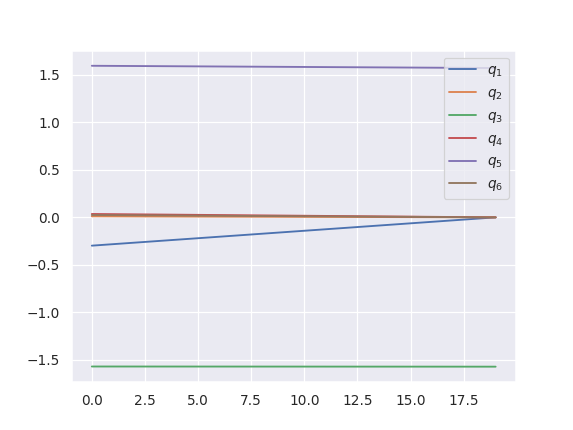

trajectory: 
  - 
    positions: [-0.2977128326892853, 0.010686562396585941, -1.5689793825149536, 0.03550398349761963, 1.5945839881896973, 0.024708127602934837]
    velocities: []
    accelerations: []
    effort: []
    time_from_start: 
      secs: 0
      nsecs:         0
  - 
    positions: [-0.28204373623195444, 0.01012411174413405, -1.5690750111612664, 0.033635352787218596, 1.5933320060110236, 0.02340769983435932]
    velocities: []
    accelerations: []
    effort: []
    time_from_start: 
      secs: 0
      nsecs:         0
  - 
    positions: [-0.26637463977462367, 0.009561661091682157, -1.569170639807579, 0.03176672207681756, 1.5920800238323498, 0.022107272065783803]
    velocities: []
    accelerations: []
    effort: []
    time_from_start: 
      secs: 0
      nsecs:         0
  - 
    positions: [-0.2507055433172929, 0.008999210439230267, -1.569266268453892, 0.02989809136641653, 1.5908280416536762, 0.020806844297208284]
    velocities: []
    accelerations: []
    effort

In [31]:
q_goal = comau_status.q_calib.copy()

jnt_traj = jnt_traj_ctrl.linear_joint_interpolate(comau_status.q, q_goal, wps=10)
qt = jnt_traj_ctrl.np2jointGoal(jnt_traj, False);
plt.plot(jnt_traj)

plt.legend([f'$q_{i}$' for i in range(1,7)]);
qt

In [32]:
len(qt.trajectory)

20

### Send trajectory to robot


in order to send this to the robot, you can now either manually send the generated joint trajectory goal via

```python
jnt_traj_ctrl.command_joint_trajectory(jnt_traj)
```

or to include the steps from above directly

```python
q0, qdes = comau_status.q, comau_status.q_calib
jnt_traj_ctrl.linear_joint_cmd(q0, q_des)
```

In [35]:
newgoal = comau_status.q_calib
newgoal[0] = np.deg2rad(70)
newgoal

array([ 1.22173,  0.     , -1.5708 ,  0.     ,  1.5708 ,  0.     ])

In [36]:
jnt_traj_ctrl.linear_joint_cmd(comau_status.q, newgoal);

In [37]:
jnt_traj_ctrl._jnt_traj_client.cancel_all_goals()

In [38]:
jnt_traj_ctrl.deactivate()